Step-1 Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

Loading the dataset


In [2]:
df = pd.read_csv(
"data/car_purchasing.csv", encoding='latin1')
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


Initial Exploratory Data Analysis


In [3]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check for missing values

     customer name                                    customer e-mail  \
0    Martina Avila  cubilia.Curae.Phasellus@quisaccumsanconvallis.edu   
1    Harlan Barnes                                eu.dolor@diam.co.uk   
2  Naomi Rodriquez  vulputate.mauris.sagittis@ametconsectetueradip...   
3  Jade Cunningham                            malesuada@dignissim.com   
4     Cedric Leach     felis.ullamcorper.viverra@egetmollislectus.net   

        country  gender        age  annual Salary  credit card debt  \
0      Bulgaria       0  41.851720    62812.09301      11609.380910   
1        Belize       0  40.870623    66646.89292       9572.957136   
2       Algeria       1  43.152897    53798.55112      11160.355060   
3  Cook Islands       1  58.271369    79370.03798      14426.164850   
4        Brazil       1  57.313749    59729.15130       5358.712177   

     net worth  car purchase amount  
0  238961.2505          35321.45877  
1  530973.9078          45115.52566  
2  638467.1773      

Step 2: Handle Missing Values


In [4]:
numerical_cols = ['age', 'annual Salary',
                  'credit card debt', 'net worth', 'car purchase amount']
# 'customer name' and 'customer e-mail' might not be directly useful for modeling
categorical_cols = ['country', 'gender', 'customer name', 'customer e-mail']

for col in numerical_cols:
    if df[col].isnull().any():
        mean_imputer = SimpleImputer(strategy='mean')
        df[col] = mean_imputer.fit_transform(df[[col]])

for col in categorical_cols:
    if df[col].isnull().any():
        mode_imputer = SimpleImputer(strategy='most_frequent')
        df[col] = mode_imputer.fit_transform(df[[col]])

print(df.isnull().sum())

customer name          0
customer e-mail        0
country                0
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64


Step 3: Detect and Handle Outliers


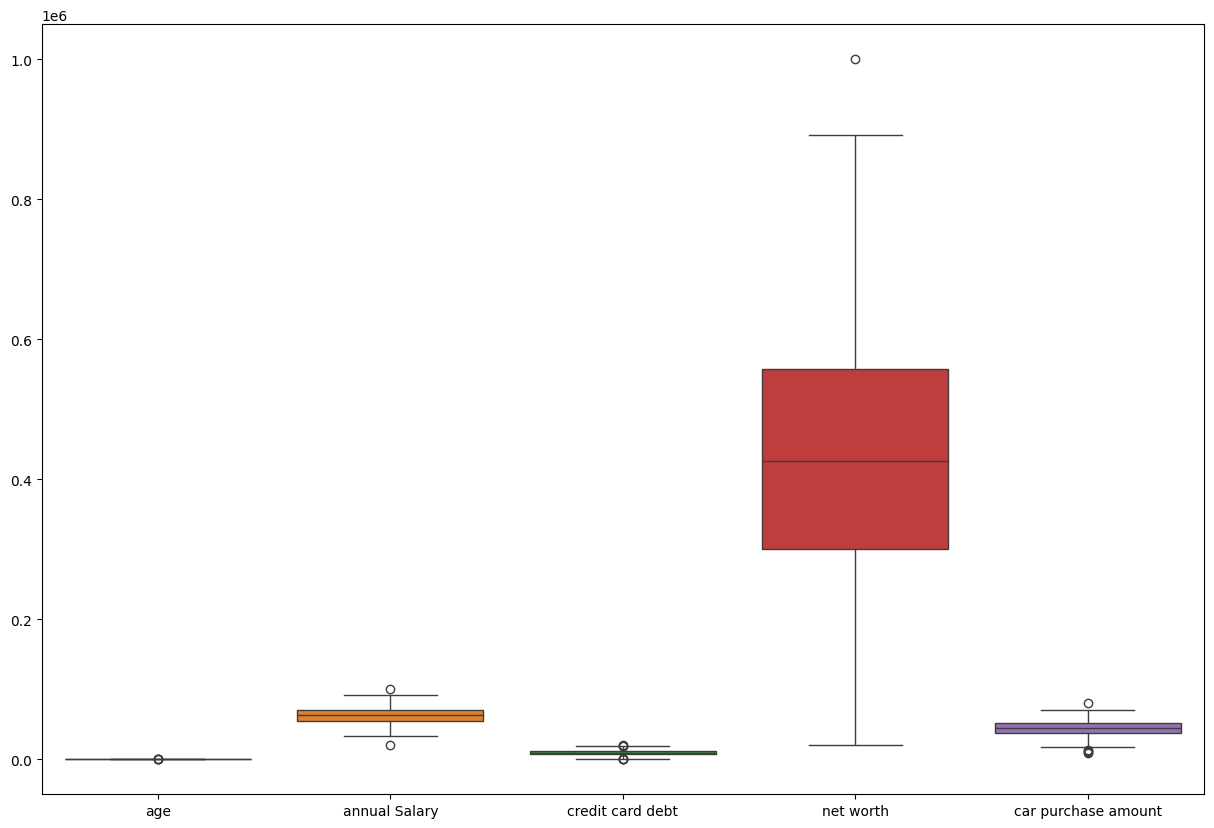

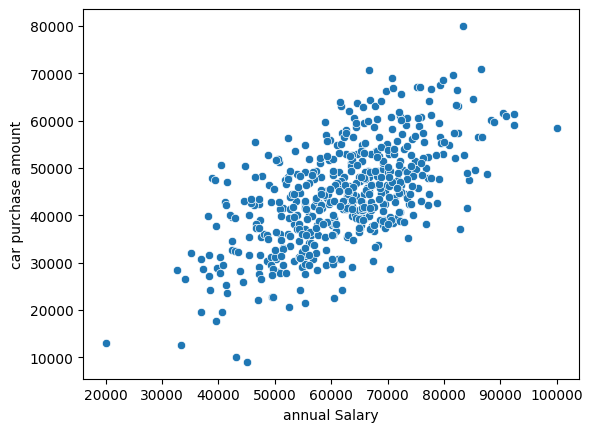

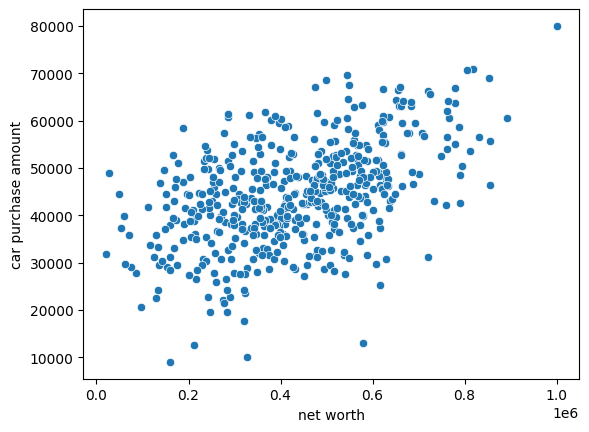

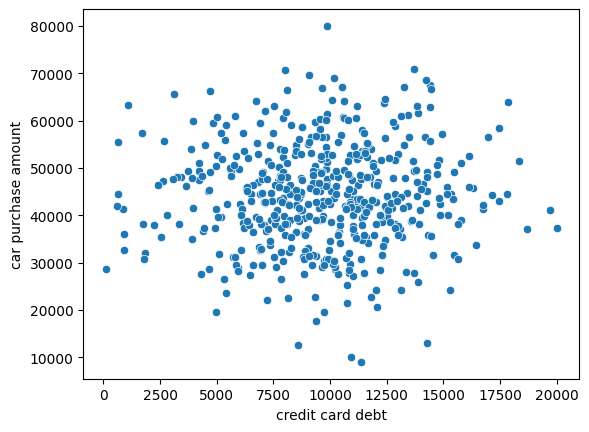

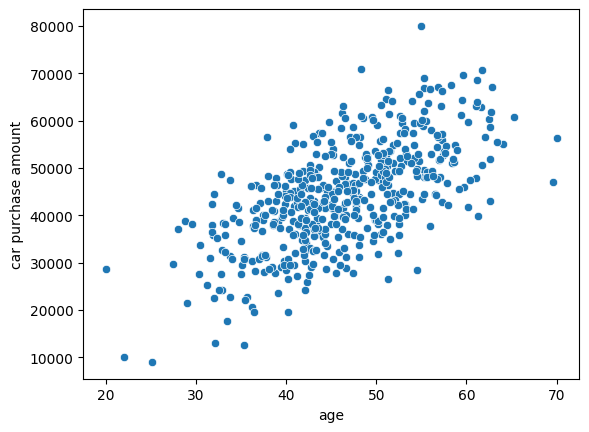

In [5]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[['age', 'annual Salary',
            'credit card debt', 'net worth', 'car purchase amount']])
plt.show()

sns.scatterplot(x=df['annual Salary'], y=df['car purchase amount'])
plt.show()
sns.scatterplot(x=df['net worth'], y=df['car purchase amount'])
plt.show()
sns.scatterplot(x=df['credit card debt'], y=df['car purchase amount'])
plt.show()
sns.scatterplot(x=df['age'], y=df['car purchase amount'])
plt.show()

In [6]:
# Example using IQR for 'car purchase amount'
Q1 = df['car purchase amount'].quantile(0.25)
Q3 = df['car purchase amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['car purchase amount'] >= lower_bound) &
        (df['car purchase amount'] <= upper_bound)]
print(f"Shape after outlier removal: {df.shape}")

Shape after outlier removal: (495, 9)


In [7]:
df = df.copy()
df['debt_to_income'] = df['credit card debt'] / (df['annual Salary'] + 1e-6)
df['debt_to_networth'] = df['credit card debt'] / (df['net worth'] + 1e-6)

In [ ]:
# df = df.drop(['customer name', 'customer e-mail'], axis=1)

In [8]:
numerical_features = ['age', 'annual Salary', 'credit card debt',
                      'net worth', 'debt_to_income', 'debt_to_networth', 'gender']
categorical_features = ['country',]  # 'gender' is already numerical
target_feature = 'car purchase amount'

In [9]:
print(df['country'].value_counts())  # First, see the counts of each country

# Define a threshold based on the value counts.
# For example, if you want to group countries that appear less than 5 times:
threshold = 5

country_counts = df['country'].value_counts()
infrequent_countries = country_counts[country_counts < threshold].index
df['country'] = df['country'].replace(infrequent_countries, 'Other')
print("Number of unique countries after grouping:", df['country'].nunique())
print(df['country'].value_counts())  # See the updated counts

Mauritania             6
Israel                 6
Laos                   5
Liechtenstein          5
Kyrgyzstan             5
                      ..
El Salvador            1
Denmark                1
Oman                   1
Trinidad and Tobago    1
marlal                 1
Name: country, Length: 211, dtype: int64
Number of unique countries after grouping: 17
Other                413
Mauritania             6
Israel                 6
Guinea                 5
Saint Barthélemy       5
Equatorial Guinea      5
Liechtenstein          5
Bolivia                5
Kyrgyzstan             5
Algeria                5
Laos                   5
Samoa                  5
Bhutan                 5
Iraq                   5
Greenland              5
Armenia                5
Grenada                5
Name: country, dtype: int64


In [10]:
numerical_features = ['age', 'annual Salary', 'credit card debt',
                      'net worth', 'debt_to_income', 'debt_to_networth', 'gender']
categorical_features = ['country']
# columns_to_drop = ['customer name', 'customer e-mail']
all_features = numerical_features + categorical_features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

X = df.drop('car purchase amount', axis=1)
X_processed = preprocessor.fit_transform(X)
# Get feature names from the fitted preprocessor
feature_names = preprocessor.get_feature_names_out()
X_processed = pd.DataFrame(X_processed, columns=feature_names)
y = df['car purchase amount']

print("Processed feature names:", feature_names)
print("Shape of processed X:", X_processed.shape)
print("Shape of y:", y.shape)
print(X_processed.head())

Processed feature names: ['num__age' 'num__annual Salary' 'num__credit card debt' 'num__net worth'
 'num__debt_to_income' 'num__debt_to_networth' 'num__gender'
 'cat__country_Algeria' 'cat__country_Armenia' 'cat__country_Bhutan'
 'cat__country_Bolivia' 'cat__country_Equatorial Guinea'
 'cat__country_Greenland' 'cat__country_Grenada' 'cat__country_Guinea'
 'cat__country_Iraq' 'cat__country_Israel' 'cat__country_Kyrgyzstan'
 'cat__country_Laos' 'cat__country_Liechtenstein'
 'cat__country_Mauritania' 'cat__country_Other'
 'cat__country_Saint Barthélemy' 'cat__country_Samoa']
Shape of processed X: (495, 24)
Shape of y: (495,)
   num__age  num__annual Salary  num__credit card debt  num__net worth  \
0 -0.576675            0.044790               0.576729       -1.121547   
1 -0.702005            0.380387              -0.005898        0.581772   
2 -0.410457           -0.744014               0.448261        1.208784   
3  1.520847            1.493831               1.382619        0.684580   


Step 6: Split Data into Training and Testing Sets.


In [11]:
from sklearn.model_selection import train_test_split

# Split the processed features (X_processed) and the target (y)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (396, 24)
Shape of X_test: (99, 24)
Shape of y_train: (396,)
Shape of y_test: (99,)


Linear Regression


In [12]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model on the training data
linear_model.fit(X_train, y_train)

print("Linear Regression model trained!")

Linear Regression model trained!


Random Forest


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

print("Random Forest Regressor model trained!")

Random Forest Regressor model trained!


gradient boosting


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model on the training data
gb_model.fit(X_train, y_train)

print("Gradient Boosting Regressor model trained!")

Gradient Boosting Regressor model trained!


Evaluate the model


In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"Evaluation metrics for {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  R-squared (R2): {r2:.2f}")
    print("-" * 30)


# Make predictions on the test set
linear_predictions = linear_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

# Evaluate the models
evaluate_model(y_test, linear_predictions, "Linear Regression")
evaluate_model(y_test, rf_predictions, "Random Forest")
evaluate_model(y_test, gb_predictions, "Gradient Boosting")

Evaluation metrics for Linear Regression:
  Mean Squared Error (MSE): 1.99
  Root Mean Squared Error (RMSE): 1.41
  R-squared (R2): 1.00
------------------------------
Evaluation metrics for Random Forest:
  Mean Squared Error (MSE): 7738031.50
  Root Mean Squared Error (RMSE): 2781.73
  R-squared (R2): 0.93
------------------------------
Evaluation metrics for Gradient Boosting:
  Mean Squared Error (MSE): 4185952.57
  Root Mean Squared Error (RMSE): 2045.96
  R-squared (R2): 0.96
------------------------------


In [16]:
from sklearn.model_selection import GridSearchCV

# Example: Tuning the hyperparameters of the Random Forest Regressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                              cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

print("Best hyperparameters for Random Forest:", best_rf_params)

# Evaluate the best model on the test set
best_rf_predictions = best_rf_model.predict(X_test)
evaluate_model(y_test, best_rf_predictions, "Best Random Forest")

# Example: Tuning the hyperparameters of the Gradient Boosting Regressor
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                              cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_gb_model = grid_search_gb.best_estimator_
best_gb_params = grid_search_gb.best_params_

print("Best hyperparameters for Gradient Boosting:", best_gb_params)

# Evaluate the best model on the test set
best_gb_predictions = best_gb_model.predict(X_test)
evaluate_model(y_test, best_gb_predictions, "Best Gradient Boosting")

Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Evaluation metrics for Best Random Forest:
  Mean Squared Error (MSE): 7148185.05
  Root Mean Squared Error (RMSE): 2673.61
  R-squared (R2): 0.94
------------------------------
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation metrics for Best Gradient Boosting:
  Mean Squared Error (MSE): 3901350.59
  Root Mean Squared Error (RMSE): 1975.18
  R-squared (R2): 0.97
------------------------------


In [16]:
# Get feature importances from Random Forest
if hasattr(best_rf_model, 'feature_importances_'):
    importances_rf = best_rf_model.feature_importances_
    feature_importance_rf = pd.Series(importances_rf, index=X_train.columns)
    feature_importance_rf = feature_importance_rf.sort_values(ascending=False)
    print("Feature Importance from Random Forest:")
    print(feature_importance_rf)

# Get feature importances from Gradient Boosting
if hasattr(best_gb_model, 'feature_importances_'):
    importances_gb = best_gb_model.feature_importances_
    feature_importance_gb = pd.Series(importances_gb, index=X_train.columns)
    feature_importance_gb = feature_importance_gb.sort_values(ascending=False)
    print("\nFeature Importance from Gradient Boosting:")
    print(feature_importance_gb)

Feature Importance from Random Forest:
num__age                          0.379373
num__annual Salary                0.366027
num__net worth                    0.218283
num__debt_to_networth             0.018977
num__credit card debt             0.006986
num__debt_to_income               0.006148
num__gender                       0.001835
cat__country_Other                0.000786
cat__country_Bolivia              0.000372
cat__country_Bhutan               0.000167
cat__country_Liechtenstein        0.000138
cat__country_Samoa                0.000130
cat__country_Algeria              0.000118
cat__country_Iraq                 0.000095
cat__country_Israel               0.000088
cat__country_Armenia              0.000086
cat__country_Guinea               0.000078
cat__country_Kyrgyzstan           0.000076
cat__country_Mauritania           0.000058
cat__country_Greenland            0.000050
cat__country_Grenada              0.000043
cat__country_Equatorial Guinea    0.000041
cat__country_La

In [17]:
if hasattr(linear_model, 'coef_'):
    coefficients = pd.Series(linear_model.coef_, index=X_train.columns)
    print("Coefficients from Linear Regression:")
    print(coefficients.sort_values(ascending=False))

Coefficients from Linear Regression:
num__age                          6587.881553
num__annual Salary                6425.673472
num__net worth                    4968.778957
cat__country_Israel                  1.431636
cat__country_Bhutan                  0.884959
cat__country_Armenia                 0.790404
cat__country_Bolivia                 0.685830
cat__country_Laos                    0.548467
cat__country_Iraq                    0.512652
cat__country_Guinea                  0.337505
cat__country_Mauritania              0.173956
cat__country_Saint Barthélemy        0.144512
num__debt_to_income                  0.002039
num__debt_to_networth               -0.017992
num__gender                         -0.050532
cat__country_Kyrgyzstan             -0.129913
num__credit card debt               -0.131850
cat__country_Other                  -0.271656
cat__country_Samoa                  -0.331060
cat__country_Liechtenstein          -0.359403
cat__country_Grenada                -0.5107

In [ ]:
# Select the features from the original DataFrame 'df' in the correct order
feature_order = numerical_features + categorical_features
X_full = df[feature_order]

# Preprocess the entire feature set using the fitted ColumnTransformer
X_full_processed = preprocessor.transform(X_full)

# Make predictions on the entire processed feature set
full_predictions = gb_model.predict(X_full_processed)

# Add the predictions to the original DataFrame 'df'
df['predicted_car_purchase_amount'] = full_predictions

# Display the original data with the predictions
print(df[['customer name', 'car purchase amount',
      'predicted_car_purchase_amount']].head())

     customer name  car purchase amount  predicted_car_purchase_amount
0    Martina Avila          35321.45877                   38279.224956
1    Harlan Barnes          45115.52566                   44656.697862
2  Naomi Rodriquez          42925.70921                   43142.416008
3  Jade Cunningham          67422.36313                   67325.748334
4     Cedric Leach          55915.46248                   55906.121237


c:\Users\msree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
